In [1]:
%matplotlib inline  

import sys, os, re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
sns.set_theme()

In [2]:
def gk_volatility( df ):
    aux1 = 0.5*np.power((np.log(df.high)-np.log(df.low)),2)
    aux2 = (2.*np.log(2) - 1)
    aux3 = np.power((np.log(df.close)-np.log(df.open)),2)
    return aux1-aux2*aux3

def speed_decay( df, series ):
    max_ = df[series].max()
    min_ = df[series].min()
    return (max_ - min_)/max_

In [3]:
pat    = '_ETH.csv' 
folder = 'data/'
files  = [folder + i for i in os.listdir(folder) if re.search(pat, i)]

data = {}
days = []
for f in files:
    d  = f.split("_")[0].replace(folder,"")
    df = pd.read_csv(f)
    df.columns = [i.lower() for i in df.columns]
    df.date = pd.to_datetime(df.date)
    df      = df.sort_values(by="date")
    # Calculate volatilities
    df['gk_volatility'] = gk_volatility(df)
    # Calculate rolling change
    df['1m_change'] = df.close.pct_change(periods=1)
    df['1h_change'] = df.close.pct_change(periods=60)
    data[d] = df
    days.append(d)
    
days = sorted([dt.datetime.strptime(i, '%Y%m%d') for i in days])
days = [i.strftime('%Y%m%d') for i in days]

In [4]:
x = []
for d in days:
    x.append((d, '{:.3f}%'.format(speed_decay(data[d],'close')*100)))

pd.DataFrame(x,columns=['date','max_drop'])

,date,max_drop
0,20200312,48.107%
1,20210519,44.565%
2,20210523,27.027%
3,20210921,14.268%
4,20211214,4.995%
5,20220121,18.285%
6,20220122,11.875%


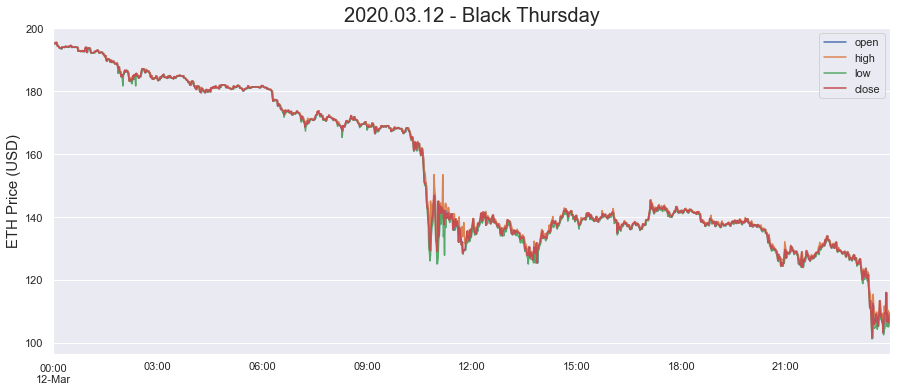

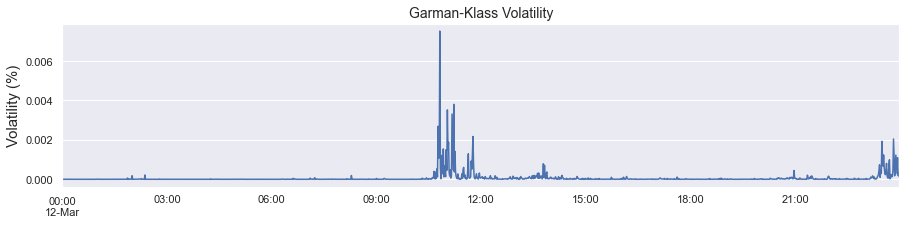

In [5]:
black_thursday = data['20200312'].copy()


fig, ax = plt.subplots(figsize=(15,6))
to_plot = black_thursday.copy()
to_plot.index = to_plot.date
to_plot[['open','high','low','close']].plot(ax=ax)
ax.set_title('2020.03.12 - Black Thursday', fontsize = 20)
ax.set_ylabel('ETH Price (USD)', fontsize = 15)
ax.set_xlabel('')
plt.show()

fig, ax = plt.subplots(figsize=(15,3))
to_plot['gk_volatility'].plot(ax=ax)
ax.set_title("Garman-Klass Volatility", fontsize = 14)
ax.set_ylabel('Volatility (%)', fontsize = 15)
ax.set_xlabel('')
plt.show()

In [6]:
days.remove('20200312')

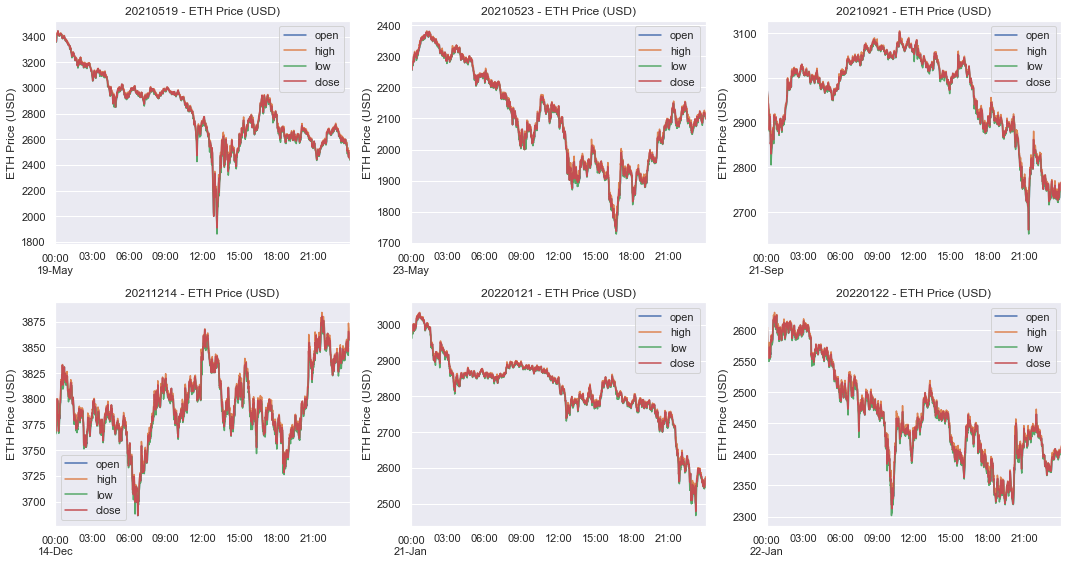

In [7]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
axe = axes.ravel()

for i,d in enumerate(days):
    to_plot       = data[d].copy()
    to_plot.index = to_plot.date
    to_plot.index.name = None
    to_plot       = to_plot[['open','high','low','close']]
    axe[i].set_ylabel('ETH Price (USD)')
    axe[i].set_xlabel('')
    axe[i].set_title('{0} - ETH Price (USD)'.format(d))
    to_plot.plot(ax=axe[i])
    
plt.tight_layout()
plt.show()

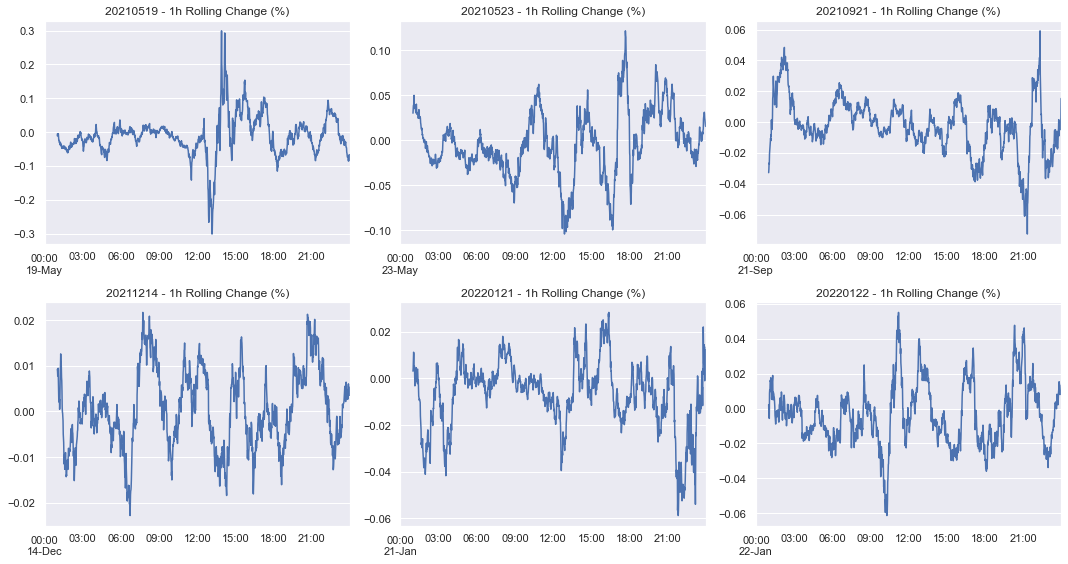

In [8]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
axe = axes.ravel()

for i,d in enumerate(days):
    to_plot       = data[d].copy()
    to_plot.index = to_plot.date
    to_plot.index.name = None
    to_plot       = to_plot['1h_change']
    axe[i].set_ylabel('')
    axe[i].set_xlabel('')
    axe[i].set_title('{0} - 1h Rolling Change (%)'.format(d))
    to_plot.plot(ax=axe[i])
    
plt.tight_layout()
plt.show()

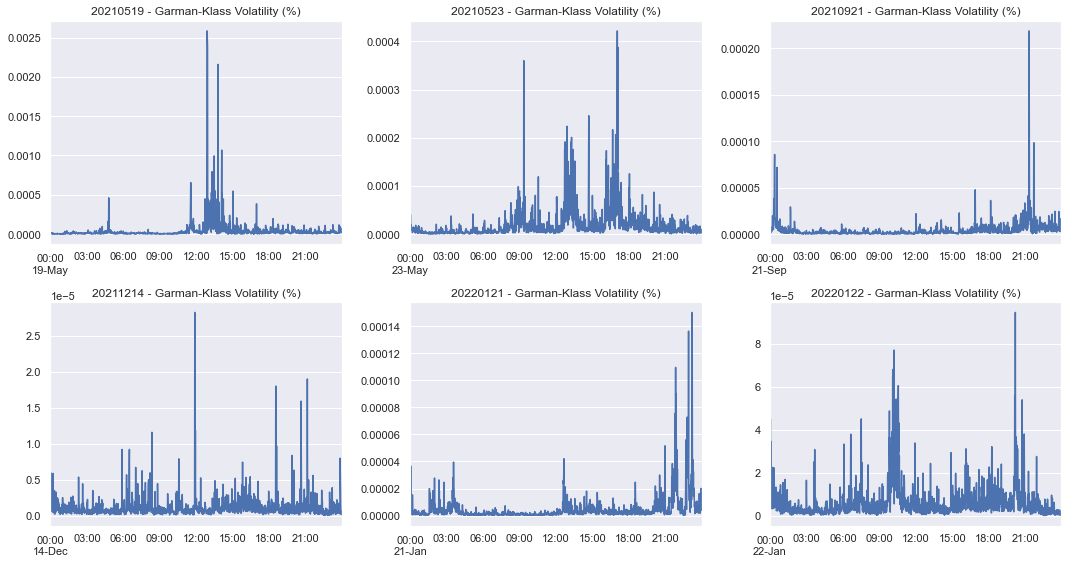

In [9]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
axe = axes.ravel()

for i,d in enumerate(days):
    to_plot       = data[d].copy()
    to_plot.index = to_plot.date
    to_plot.index.name = None
    to_plot       = to_plot['gk_volatility']
    axe[i].set_xlabel('')
    axe[i].set_title("{0} - Garman-Klass Volatility (%)".format(d))
    to_plot.plot(ax=axe[i])
    
plt.tight_layout()
plt.show()

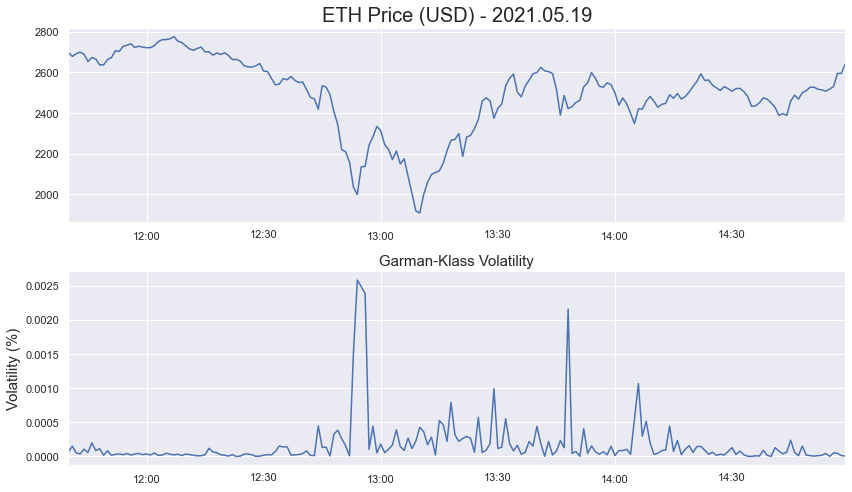

In [10]:
df = data['20210519'].copy()

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,7))
to_plot = df.copy()
to_plot.index = to_plot.date
to_plot.index.name = None
to_plot.close[700:900].plot(ax=ax1)
ax1.set_title('ETH Price (USD) - 2021.05.19', fontsize = 20)

to_plot.gk_volatility[700:900].plot(ax=ax2)
ax2.set_title("Garman-Klass Volatility".format(d) , fontsize = 15)
ax2.set_ylabel('Volatility (%)', fontsize = 15)
plt.tight_layout()
plt.show()

In [11]:
def geometric_brownian_motion( initial_price, mu, sigma, maturity_time, dt, pdf = 'normal' ):
    prices = [ initial_price ]
    time   = 0
    while( time + dt <= maturity_time):
        aux1      = ( mu - 0.5*( sigma**2 ) )*dt
        # pdf sampling
        if pdf == 'normal':
            random_step = np.sqrt( dt ) * np.random.normal( 0 , 1 )
        elif pdf == 'laplace':
            random_step = np.sqrt( dt ) * np.random.laplace( 0 , 1 )
        else:
            return 'error'
        
        aux2        = sigma * random_step
        aux3        = np.exp( aux1 + aux2 )
        new_price   = prices[-1]*aux3
        prices.append( new_price )
        
        time += dt
        
    # In case there isnt a perfect timestep dt
    if ( maturity_time - time) > 0:
        aux1      = ( mu - 0.5*( sigma**2 ) )*( maturity_time - time )
        aux2      = sigma*np.random.normal( 0 , np.sqrt( maturity_time - time ) )
        aux3      = np.exp( aux1 + aux2 )
        new_price = prices[-1]*aux3
        prices.append( new_price )
        
    return prices

def get_stairstep_exponential( buf, cut, step, tail, cusp ):
    top     = 100 * buf  
    minutes = np.arange( 0, tail + 20 )

    stair_step_exponential = []
    for _min_ in minutes:
        aux1 = top * np.power( cut, int( _min_/step ))
        aux2 = top * cusp
        if aux1 >= aux2:
            stair_step_exponential.append(aux1)

    return np.array(minutes), np.array(stair_step_exponential)

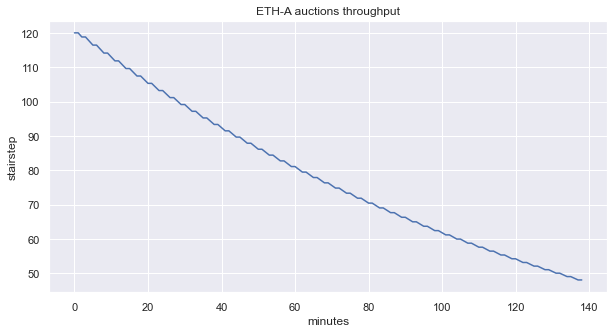

In [12]:
buf  = 1.20
cut  = 0.99
step = (.90/60)*100
tail = 140
cusp = 0.4

stair_step_exponential = get_stairstep_exponential( buf, cut, step, tail, cusp )

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('minutes')
ax.set_ylabel('stairstep')
plt.plot(stair_step_exponential[1])
ax.set_title('ETH-A auctions throughput')
plt.show()

In [13]:
buf  = 1.20
cut  = 0.99
step = (.90/60)*100
tail = 140
cusp = 0.4

df              = pd.DataFrame()
ss_expo         = get_stairstep_exponential( buf, cut, step, tail, cusp )

length_crash    = 140*60

df['seconds']   = np.arange(length_crash)
mu    = ss_expo[1].mean()/100
sigma = ss_expo[1].std()/100

df['price']     = geometric_brownian_motion( 100, -mu, sigma, 1, 1/(length_crash - 2) )
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

now = dt.datetime.now()
datetime_range(now, now + dt.timedelta(hours = 5), dt.timedelta(seconds=1))

<generator object datetime_range at 0x7f7d28469dd0>

In [14]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

time = [dt.strftime('%Y-%m-%d T%H:%M:%S') for dt in 
       datetime_range(dt.datetime(2022, 9, 5, 14,0,0), dt.datetime(2022, 9, 5, 17,0,0), 
       dt.timedelta(seconds=1))]

df['time'] = pd.to_datetime(time[0:len(df)])

df = df.set_index('time')

df_f = df['price'].resample('1Min').ohlc(_method='ohlc')
df_f.head()

,open,high,low,close
time,,,,
2022-09-05 14:00:00,100.000000,101.736055,99.441971,100.268596
2022-09-05 14:01:00,100.205954,101.247535,98.849967,99.113028
2022-09-05 14:02:00,99.031496,99.031568,97.364448,97.752977
2022-09-05 14:03:00,98.001496,98.495004,96.294960,97.761389
2022-09-05 14:04:00,97.940495,99.391158,96.849290,96.849290


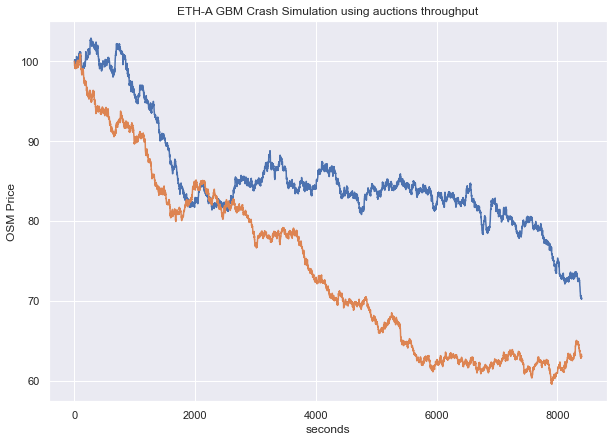

In [15]:
paths = []
for i in range(100):
    gbm = geometric_brownian_motion( 100, -mu/2, sigma/2, 1, 1/(60*140) , 'laplace' )
    paths.append(gbm)

fig, ax = plt.subplots(figsize=(10,7))
for path in paths[0:2]:
    plt.plot(path)

ax.set_xlabel('seconds')
ax.set_ylabel('OSM Price')
ax.set_title('ETH-A GBM Crash Simulation using auctions throughput')
plt.show()

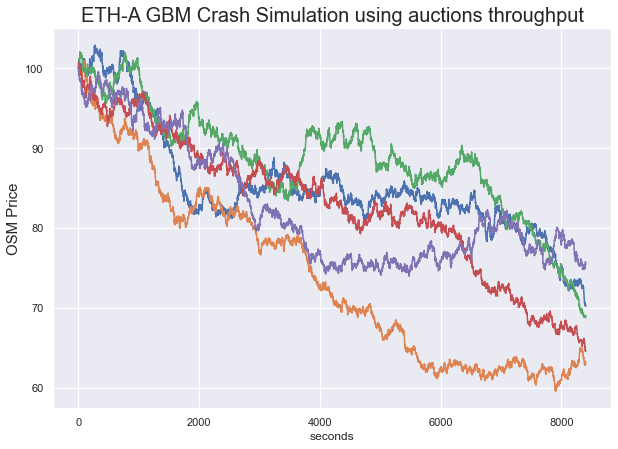

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
for path in paths[0:5]:
    plt.plot(path)

ax.set_xlabel('seconds')
ax.set_ylabel('OSM Price', fontsize=15)
ax.set_title('ETH-A GBM Crash Simulation using auctions throughput', fontsize=20)
plt.show()

In [17]:
x = []
for path in paths:
    df             = pd.DataFrame()
    df['price']    = path
    df['time']     = pd.to_datetime(time[0:len(df)])
    df             = df.set_index('time')
    df             = df['price'].resample('1Min').ohlc(_method='ohlc')
    df['vol_pure'] = gk_volatility(df)
    x.append(df)

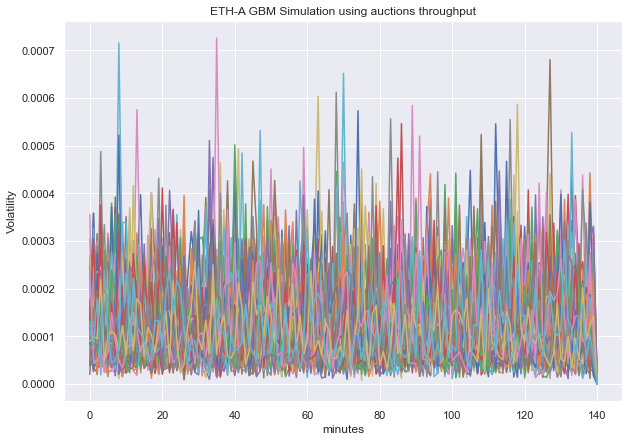

In [18]:
fig, ax = plt.subplots(figsize=(10,7))

for df in x:
    plt.plot(df.vol_pure.reset_index().vol_pure)
    
ax.set_xlabel('minutes')
ax.set_ylabel('Volatility')
ax.set_title('ETH-A GBM Simulation using auctions throughput')
plt.show()

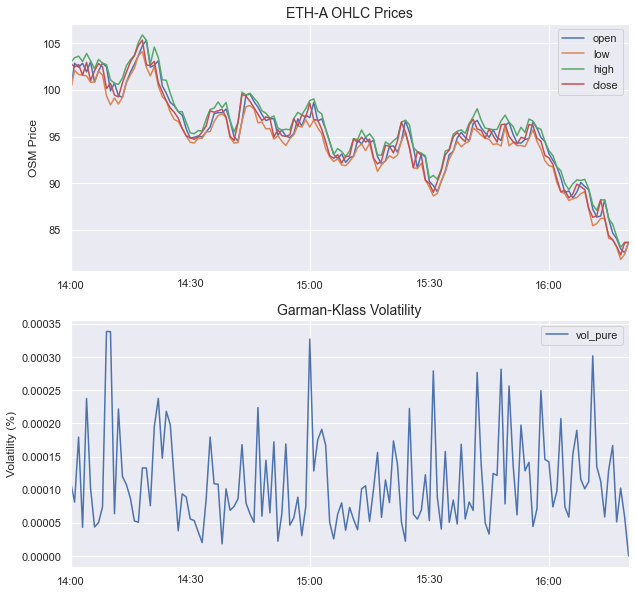

In [33]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax.set_xlabel('minutes')
ax.set_ylabel('stairstep')
to_plot = df.copy()
to_plot.index.name = None
to_plot[['open','low','high','close']].plot(ax=ax1)
ax1.set_title('ETH-A OHLC Prices', fontsize=14)
ax1.set_ylabel('OSM Price')

to_plot[['vol_pure']].plot(ax=ax2)
ax2.set_title('Garman-Klass Volatility', fontsize=14)
ax2.set_ylabel('Volatility (%)')
plt.show()